# The script

This script derives the equations of motion of the wind turbine model described below, i.e. the system of differential equations describing the structural deflection, velocity and accleration of the wind turbine blades and components. Then a numerical python (numpy) code is generated to solve the equations of motion on time.

# Problem definition

The figure below illustrates the wind turbine structural and kinematic model, the position vectors and the reference frames used to model the wind turbine movement. The inertial frame of reference $O_0$ origin is located on the wind turbine basis. The origin $O_1$ of the first moving reference frame is located at the tower top and it translates and rotates based with tower top deformation. The origin of $O_2$ is attached to the nacelle and is tilted of an angle $\theta_{tilt}$ in relation to $O_1$. The third frame of reference $O_3$ origin is located on the tip of wind turbine shaft, it is rotated $\left[\eta + \theta_b\left(t\right) + \theta_{s,y}\left(t\right)\right]$ in relation to the second frame of reference, where $\theta_b\left(t\right)$ is the shaft azimuth angle, $\theta_{s,y}\left(t\right)$ is the shaft torsional deformation and $\eta$ is initial azimuth angle of the blade $b$. The fourth frame of reference $O_4$ is located at blade root, which is conned at an angle $\theta_{cone}$ in relation to the rotor plane.

The nacelle is inclined upward in relation to the horizontal by and angle $\theta_{tilt}$ and the blades are inclined forward in relation to the rotor plane by an angle $\theta_{cone}$. The displacement of the nacelle is modelled by the two linear springs $k_x^t$ and $k_y^t$ and two angular angular springs $G_x^t$ and $G_z^t$, representing the stiffness of the wind turbine tower. The shaft deformation is modelled by an angular spring on its tip. The blades displacement is modelled as a linear combination of its mode-shapes.

![title](fig_turbine_views_2.svg)

## Importing libraries

One of the main advantages of the using a symbolic package inside a programming language as Python instead of a stand-alone software is the possibility of combining multiple packages together. In the symbolic script, the main packages imported are “Sympy” for handling the symbolic derivations and “Joblib” for handling the parallel computations, python standard data structures are also used extensively. Another convenience of Python is the possibility of adapting the functionality of a package to suit the project specific needs through inheritance of a class and overriding some of its methods. In the present case, the code generator “NumpyPrinter” from Sympy was inherited into the class “MyPrinter”. The “MyPrinter” class methods will be discussed in detail later in this notebook.

In [1]:
from IPython.display import display
from os import system as syst
import sys
import sympy as sym
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
import time
import psutil 

from my_printer import MyPrinter
from joblib import Parallel, delayed
import multiprocessing

In [2]:
# Start printing using LaTeX
sym.init_printing()

# Start couting time
t_start = time.time()

# Create or erase log file used by the parallelized functins
file_log = open('file_log.txt', 'wt')
file_log.close()

# Number of physical cores available for parallelisation
n_cores = psutil.cpu_count(logical = False)

# Parallel function verbose option
par_verbose = 1

## Script functions

In this cell, some functions that will be used are created. Combining the libraries methods, the functions increase the efficiency and make the code more readable. All the functions defined in this section, and every where in the project, follow the PEP8 standard and their functionality and parameters can be called using the help() function.

In [3]:
#%% Personal functions

def rotate_matrix(angle,axis): # return A
    '''
    Generates a transformation matrix.
    
    Parameters
    ----------
    angle : sympy.Symbol or sympy.Function
            [rad] angle between the two reference frames along the 'axis'
    axis : str
           axis of roation. 'x', 'y' and 'z'.
    
    Returns
    -------
    A : sympy.Matrix [:, :]
        transformation matrix from reference frame 1 to reference frame 2.
    '''
    if (axis=='x'):
        A = sym.Matrix([[1, 0, 0],
                    [0, sym.cos(angle), sym.sin(angle)],
                    [0, -sym.sin(angle), sym.cos(angle)]])
    elif (axis=='y'):
        A = sym.Matrix([[sym.cos(angle), 0, -sym.sin(angle)],
                    [0, 1, 0],
                    [sym.sin(angle), 0, sym.cos(angle)]])
    elif (axis=='z'):
        A = sym.Matrix([[sym.cos(angle), sym.sin(angle), 0],
                    [-sym.sin(angle), sym.cos(angle), 0],
                    [0, 0, 1]])
    else:
        print('error in rotate_matrix function')
    
    return A

def red(M): # return A
    '''
    Reduce or simplify a matrix M.
    
    Parameters
    ----------
    M : sympy.matrix [:, :]
    
    Returns
    -------
    A : sympy.matrix [:, :]
        M simplified
    '''
    A = M.copy().as_mutable()
    A = sym.simplify(A.doit().expand(trig=True))
    return A

def coeficient_matrix_par(E, q, b=None, c=None): # return M
    '''
    Collects the terms o equatios E[:] that are linearly proportional to each 
    of the terms in the array q[:] and arrange the equation into a matrix M
    such that:
    
    E[:] = M[:, :] . q[:]
    
    The equation is ran in parallel over the rows of E[:]
    
    Parameters
    ----------
    E : sympy.matrix [:]
        system of equations E[j] = 0
    q : sympy.matrix [:]
        list of sympy symbols, functions or expressions
    
    Returns
    -------
    M : sympy.matris [:, :]
        matrix M satisfying equation E[:] = M[:, :] . q[:]
    '''
    
    # Function that will be executed in parallel
    def func_M(E, q, i, b=None, c=None):
        #--
        toto = sym.symbols('toto')
        if (b is None): b = [toto for i in range(len(q))]
        if (c is None): c = [toto for i in range(len(q))]
        #--
        M = sym.zeros(len(q),1)
        for j in range(q.shape[0]):
            t_1 = time.time()
            M[j] = E.coeff(b[j], n=0).coeff(c[j], n=0).coeff(q[j])
            t_2 = time.time();
            file_log = open('file_log.txt', 'a')
            print((i, j), end=' ', file=file_log)
            print(t_2 - t_1, file=file_log)
            file_log.close()
        #--
        return (i, M)

    # Executing the function in parallel
    totos = Parallel(n_jobs=n_cores, verbose=par_verbose)(delayed(func_M)(E[i], q, i, b, c) for i in range(len(q)) )

    # Collecting the values
    M = sym.zeros(len(q), len(q))
    for toto in totos:
        i = toto[0]
        for j in range(len(q)):
            M[i, j] = toto[1][j]
    del totos
    #--
    return M

def func_var_subs(var, dict_1, dict_2, i, j):
    '''
    Substitutes the expression in var using the dictionaries dict_1 and dict_2
    on this order. The counters i an j are used so this function can be called
    by parallelized functios. The ipython console cannot be called by 
    parallelised functions, so the log file is used to register the function
    progress.
    
    Parameters
    ----------
    var : sympy expression
    dict_1 : dictionary {key: value}
             key : sympy symbol, function or expression
             value : sympy symbol, function or expression
             the keys on dict_1 are substitued by corresponding values
    dict_2 : dictionary {key: value}
             key : sympy symbol, function or expression
             value : sympy symbol, function or expression
             the keys on dict_1 are substitued by corresponding values
    i : int
        counter used so the function can be called by parallelized functios
    j : int
        counter used so the function can be called by parallelized functios
    
    Returns
    -------
    (i, j var) : tuple
                 i : int
                     counter passed to the function as a paremeter so the
                     function can be called by parallelized functios
                 j : int
                     counter passed to the function as a paremeter so the
                     function can be called by parallelized functios
                 var : sympy expression
                       expression passed to the function where the keys in
                       dict_1 and dict_2 have been replace by their
                       correspondent values on this order, i.e. firt dict_1 and
                       then dict_2.
    '''
    
    t_1 = time.time()
    #--
    var = var.expand(trig=True).subs(dict_1).subs(dict_2)
    #--
    t_2 = time.time()
    file_log = open('file_log.txt', 'a')    
    print((i, j), end=' ', file=file_log)
    print(t_2 - t_1, file=file_log)
    file_log.close()
    return (i, j, var)

def assumptions(M, dict_1, dict_2={}):
    '''
    Substitutes the expressions in each term in the matrix M[i, j] using the
    dictionaries dict_1 and dict_2 on this order. The dictionaries contain
    assumptions used to simplify the matrix. The dictionaries can contain
    symbolic symbols, functions or expressions such as multiplications.
    
    The function func_var_subs is ran in parallel over the physical cores in to
    accelerate the process. The ipython console cannot be called by 
    parallelised functions, so the log file is used to register the function
    progress.
    
    Paramters
    ---------
    M : sympy.matrix [:, :]
        matrix of sympy expressions
    dict_1 : dictionary {key: value}
             key : sympy symbol, function or expression
             value : sympy symbol, function or expression
             the keys on dict_1 are substitued by corresponding values
    dict_2 : dictionary {key: value}
             key : sympy symbol, function or expression
             value : sympy symbol, function or expression
             the keys on dict_1 are substitued by corresponding values
    
    Returns
    -------
    M_res : sympy.matrix [:, :]
            matrix  passed to the function where the keys in dict_1 and dict_2
            have been replace by their correspondent values on this order, i.e.
            firt dict_1 and then dict_2.
    '''
    
    var = M.copy()
    totos = Parallel(n_jobs=n_cores, verbose=par_verbose)(delayed(func_var_subs)(var[i, j], dict_small, dict_small_squared, i, j) for i in range(M.shape[0]) for j in range(M.shape[1]) )
    M_res = sym.zeros(M.shape[0], M.shape[1])
    for toto in totos:
        i = toto[0]
        j = toto[1]
        M_res[i, j] = toto[2]
    del totos
    return M_res

def assumptions_madd(M, dict_1, dict_2):
    '''
    Substitutes the expressions in each term in the matrix M[i, j] using the
    dictionaries dict_1 and dict_2 on this order. The dictionaries contain
    assumptions used to simplify the matrix. The dictionaries can contain
    symbolic symbols, functions or expressions such as multiplications.
    
    The function func_var_subs is ran in parallel over the physical cores in to
    accelerate the process. The ipython console cannot be called by 
    parallelised functions, so the log file is used to register the function
    progress.
    
    Paramters
    ---------
    M : sympy.matrix [:, :]
        matrix of sympy expressions
        type(M[i, j]).__name__ must be Add for all i and j in M[:, :]
    dict_1 : dictionary {key: value}
             key : sympy symbol, function or expression
             value : sympy symbol, function or expression
             the keys on dict_1 are substitued by corresponding values
    dict_2 : dictionary {key: value}
             key : sympy symbol, function or expression
             value : sympy symbol, function or expression
             the keys on dict_1 are substitued by corresponding values
    
    Returns
    -------
    M_res : sympy.matrix [:, :]
            matrix  passed to the function where the keys in dict_1 and dict_2
            have been replace by their correspondent values on this order, i.e.
            firt dict_1 and then dict_2.
    '''
    
    possible = True
    for i_m in range(M.shape[0]):
        for j_m in range(M.shape[1]):
            if (type(M[i_m, j_m]).__name__ != 'Add'):
                possible = False
    if (not possible):
        print("I'm sorry Dave, I'm afraid I can't do that", file=sys.stderr)
    
    M_res = M.copy()
    for i_m in range(M.shape[0]):
        for j_m in range(M.shape[1]):
            arguments = list(M_res[i_m, j_m].args)
            totos = Parallel(n_jobs=n_cores, verbose=par_verbose)(delayed(func_var_subs)(arguments[i], dict_small, dict_small_squared, i, 0) for i in range(len(arguments)) )
            for toto in totos:
                i = toto[0]
                _ = toto[1]
                arguments[i] = toto[2]
            del totos
            M_res[i_m,j_m] = M_res[i_m,j_m].func(*arguments)
            
    return M_res

def func_var_simplify(var, i, j):
    '''
    This function calls the sympy methos doit, expand and simplify in order to
    reduce expression complexity without making assumptions. The counters i an
    j are used so this function can be called by parallelized functios. The
    ipython console cannot be called by parallelised functions, so the log file
    is used to register the function progress.
    
    Parameters
    ----------
    var : sympy expression
    i : int
        counter used so the function can be called by parallelized functios
    j : int
        counter used so the function can be called by parallelized functios
    
    Returns
    -------
    (i, j var) : tuple
                 i : int
                     counter passed to the function as a paremeter so the
                     function can be called by parallelized functios
                 j : int
                     counter passed to the function as a paremeter so the
                     function can be called by parallelized functios
                 var : sympy expression
                       expression simplified
    '''
    t_1 = time.time()
    #--
    var = var.doit().expand(trig=True).doit().simplify()
    #--
    t_2 = time.time()
    file_log = open('file_log.txt', 'a')    
    print((i, j), end=' ', file=file_log)
    print(t_2 - t_1, file=file_log)
    file_log.close()
    return (i, j, var)

def matrix_simplify(M):
    '''
    This function calls the sympy methos doit, expand and simplify in order to
    reduce the complexity of each term of the matrix M[:, :] without making 
    assumptions.
    
    The function func_var_subs is ran in parallel over the physical cores in to
    accelerate the process. The ipython console cannot be called by
    parallelised functions, so the log file is used to register the function
    progress.
    
    Paramters
    ---------
    M : sympy.matrix [:, :]
        matrix of sympy expressions
    
    Returns
    -------
    M_s : sympy.matrix [:, :]
          matrix  passed to the function simplified
    '''
    
    var = M.copy()
    totos = Parallel(n_jobs=n_cores, verbose=par_verbose)(delayed(func_var_simplify)(var[i, j], i, j) for i in range(M.shape[0]) for j in range(M.shape[1]) )
    M_s = sym.zeros(M.shape[0], M.shape[1])
    for toto in totos:
        i = toto[0]
        j = toto[1]
        M_s[i, j] = toto[2]
    del totos
    return M_s

def func_subs_integral(var, i, j, dz, z, R):
    '''
    This function calls the integrate method over the expression in var. The
    terms linearly proportional to dz are selected, and the expression is
    integrated from z to R. The counters i an j are used so this function can
    be called by parallelized functios. The ipython console cannot be called by
    parallelised functions, so the log file is used to register the function
    progress.
    
    Parameters
    ----------
    var : sympy expression
          the expression must contain at least one term containing dz
    i : int
        counter used so the function can be called by parallelized functios
    j : int
        counter used so the function can be called by parallelized functios
    dz : sympy.Symbol
         infinitesimal integration variable
    z : sympy.Symbol
        integration variable
    R : sympy.Symbol
        upper integration limit
        
    Returns
    -------
    (i, j, var) : tuple
                 i : int
                     counter passed to the function as a paremeter so the
                     function can be called by parallelized functios
                 j : int
                     counter passed to the function as a paremeter so the
                     function can be called by parallelized functios
                 var : sympy expression
                       sympy expression integraed       
    '''
    
    t_1 = time.time()
    #--
    var = (var.coeff(dz).integrate((z,0,R)) + var.coeff(dz,n=0)).expand().doit()
    #--
    t_2 = time.time()
    with open('file_log.txt', 'a') as file_log:
        print('(%i, %i) %0.4f' %(i, j, t_2-t_1), file=file_log )
    return (i, j, var)

def func_integrate_par(expr, dz, z, R):
    '''
    This function calls the integrate method over the expression in var. The
    terms linearly proportional to dz are selected, and the expression is
    integrated from z to R. The expression must be constituted of additive
    terms, i.e. type(expr.core.add.Add) == sympy.core.add.Add must be True
    
    The function unc_subs_integral is ran in parallel over the physical cores
    in to accelerate the process. The ipython console cannot be called by
    parallelised functions, so the log file is used to register the function
    progress.
    
    Parameters
    ----------
    expr : sympy expression of the type sympy.core.add.Add
           the expression must contain at least one term containing dz
    dz : sympy.Symbol
         infinitesimal integration variable
    z : sympy.Symbol
        integration variable
    R : sympy.Symbol
        upper integration limit
        
    Returns
    -------
    expr_int : sympy expression
               sympy expression integraed       
    '''
    
    if ( type(expr).__name__ == 'Add' ):
        arguments = list(expr.args)
        totos = Parallel(n_jobs=n_cores, verbose=par_verbose)(delayed(func_subs_integral)(arguments[i], i, 0, dz, z, R) for i in range(len(arguments)) )
        for toto in totos:
            i = toto[0]
            # j = toto[1]
            arguments[i] = toto[2]
        del totos
        expr_int = expr.func(*arguments)
    else:
        expr_int = []
        sys.exit("expr type is not sympy.core.add.Add")
    return expr_int

def lhs_print(lhs_str, rhs):
    '''
    This function displays the sympy equations adding the left hand side
    defined in the input lhs_str.
    
    Parameters
    ----------
    lhs_str : string
              left hand side of the equation on latex notation
    rhs : sympy expression
    '''
    
    lhs = sym.Symbol(lhs_str)
    # lhs.name = lhs_str
    
    display(sym.relational.Eq(lhs, rhs, evaluate=False))

## Symbolic constants

The symbolic constants must be explicitly declared so that python nows their class methods and instances. Here we understand as constant a symblic variable that is not explicitly function of time. However, they may vary from time step
to time step.

In [4]:
z  = sym.symbols('z') # [m] blade section centre z coordinate (local frame)
dz = sym.symbols('dz')
R  = sym.symbols('R') # [m] rotor radius
m_n = sym.symbols('m_n') # [kg] nacelle mass
m_h = sym.symbols('m_h') # [kg] hub mass

I_x = sym.symbols('I_x') # [kg*m**2] nacelle moment of inertia around x axis (local frame)
I_z = sym.symbols('I_z') # [kg*m**2] nacelle moment of inertia around z axis (local frame)

h_t = sym.symbols('h_t') # [m] nacelle height
s_l = sym.symbols('s_l') # [m] shaft length
g = sym.symbols('g')     
eta = sym.symbols('eta') # [rad] blade initial azimuthal position
t = sym.symbols('t')     # [s] time
k_x = sym.symbols('k_x') # [N/m] tower top equivalent linear stiffness on x axis (local frame)
k_y = sym.symbols('k_y') # [N/m] tower top equivalent linear stiffness on y axis (local frame)

Gt_x = sym.symbols('Gt_x') # [N*m/rad] tower top equivalent angular stiffness around x axis (local frame)
Gt_z = sym.symbols('Gt_z') # [N*m/rad] tower top equivalent angular stiffness around y axis (local frame)
Gt_xy = sym.symbols('Gt_xy')
Gs_y = sym.symbols('Gs_y') # [N*m] shaft angular stiffness around y axis (local frame)

omega = sym.Matrix(sym.symbols('omega_0:3')) # blade natural frequencies

tilt = sym.symbols('theta_tilt') # [rad] shaft tilt angle
cone = sym.symbols('theta_cone') # [rad] blades cone angle
pitch = sym.symbols('theta_pitch') # [rad] blades pitch angle

pi = sym.pi # [-] pi constant
g = sym.symbols('g') # [kg*m/s**2] gravity

'''
Sometimes is convenient to use a different nomenclature to print the latex on
the Ipython console and for code generation. The dict_names gather the list of
variables where the names are changed before generating the numrical code.
'''

dict_names = {omega[i]: 'omega[%i]' %i for i in range(3)}
dict_names = {**dict_names, tilt: 'tilt', cone: 'cone', pitch: 'pitch'}

## Funtions of z

If a symbolic variable depends on another, for example the $z$ coordinate along the blade lenght, it is defined as an undefined function of that variable. Note that the module does not know the function shape, but knows their derivatives and integrals must be taken into account. A variable can be defined as a derivative of a symbolic variable.

In [5]:
'''
Symbolic variables that are an undefined function of the blade length z.
'''

# Blade section centre [m]
x = sym.Function('x')(z) # [m] blade section centre x coordinate (local frame)
y = sym.Function('y')(z) # [m] blade section centre y coordinate (local frame)

# Blade section mass per unit of lenght [kg/m]
m = sym.Function('m')(z)

# Blade mode shapes
phi_x = sym.zeros(3,1)  # matrix of mode shapes in the x direction [phi_0_x, phi_1_x, phi_2_x].T [m]
phi_y = sym.zeros(3,1)  # matrix of mode shapes in the x direction [phi_0_y, phi_1_y, phi_2_y].T [m]
for i in range(phi_x.shape[0]):
    phi_x[i] = sym.Function(('phi_%s_x' %str(i)))(z)
    phi_y[i] = sym.Function(('phi_%s_y' %str(i)))(z)

# Aerodynamic forces per unit length (generic blade)
f_x_b = sym.Function('f_b_x')(z) # force per unit length on x direction (for a generic blade) [N/m]
f_y_b = sym.Function('f_b_y')(z) # force per unit length on y direction (for a generic blade) [N/m]
f_z_b = sym.Function('f_b_z')(z) # force per unit length on z direction (for a generic blade) [N/m]
f_b = sym.Matrix([f_x_b, f_y_b, f_z_b]) # matrix with aerodynamic foreces [f_x_b, f_y_b, 0] (for a generic blade) [N/m]

# Aerodynamic forces per unit length (blades 0, 1 and 2)
f_x_0 = sym.Function('f_0_x')(z) # force per unit length on x direction (for blade 0) [N/m]
f_y_0 = sym.Function('f_0_y')(z) # force per unit length on y direction (for blade 0) [N/m]
f_z_0 = sym.Function('f_0_z')(z) # force per unit length on z direction (for blade 0) [N/m]
f_x_1 = sym.Function('f_1_x')(z) # force per unit length on x direction (for blade 1) [N/m]
f_y_1 = sym.Function('f_1_y')(z) # force per unit length on y direction (for blade 1) [N/m]
f_z_1 = sym.Function('f_1_z')(z) # force per unit length on z direction (for blade 1) [N/m]
f_x_2 = sym.Function('f_2_x')(z) # force per unit length on x direction (for blade 2) [N/m]
f_y_2 = sym.Function('f_2_y')(z) # force per unit length on y direction (for blade 2) [N/m]
f_z_2 = sym.Function('f_2_z')(z) # force per unit length on z direction (for blade 2) [N/m]

# Aerodynamic force vectors (blades 0, 1 and 2)
f_0 = sym.Matrix([f_x_0, f_y_0, f_z_0]) # matrix with foreces [f_x_b, f_y_b, 0] (for blade 0) [N/m]
f_1 = sym.Matrix([f_x_1, f_y_1, f_z_1]) # matrix with foreces [f_x_b, f_y_b, 0] (for blade 1) [N/m]
f_2 = sym.Matrix([f_x_2, f_y_2, f_z_2]) # matrix with foreces [f_x_b, f_y_b, 0] (for blade 2) [N/m]

## Functions of time

Symbolic variables which depend on the time can be declared as undefined functions as done above. The method "dynamicsymbols" has exactly the same effect, i.e. ``dynamicsymbol('theta') = sym.function('theta')(t)``. Bellow the problem variables which depend on time $t$, their first and second derivatives are declared.

In [6]:
# Time
t = sym.symbols('t') # time [s]

# Degrees of freedom
q = sym.Matrix(dynamicsymbols('q[0:14]')) # matrix of degrees of freedom [q_0, q_1, q_2, ..., q_11].T
q_dot = q.diff(t)                        # (d/dt) [q_0, q_1, q_2, ..., q_11].T
q_ddot = q_dot.diff(t)                   # (d**2/dt**2) [q_0, q_1, q_2, ..., q_11].T

# Degrees of freedom (generic blade)
qb = sym.Matrix(dynamicsymbols('qb_0:3')) # matrix of blade degrees of freedom (for a generic blade) [qb_0, qb_1, qb_2].T
qb_dot = qb.diff(t)                       # (d/dt) [qb_0, qb_1, qb_2].T
qb_ddot = qb_dot.diff(t)                  # (d**2/dt**2) [qb_0, qb_1, qb_2].T

# Shaft azimuth angle
theta = dynamicsymbols('theta') # azimuth position of blade 0 [rad]
theta_dot = theta.diff(t)       # (d/dt) theta [rad/s]
theta_ddot = theta_dot.diff(t)  # (d**2/dt**2) theta [rad/s**2]

# Rotor angular velocity
Omega = dynamicsymbols('Omega') # (d/dt) rotor angular velocity [rad/s]
Omega_dot = Omega.diff(t)       # (d**2/dt**2) Omega [rad/s**2]
Omega_ddot = Omega_dot.diff(t)

# Update the names dictionary
dict_names = {**dict_names, **{qb[j]: 'q[3*i_b+%i]' %j for j in range(3)}}

## Dictionaries

Python dictionaries, or associative arrays, are very useful in symbolic manipulation to perform substitutions. For example the symbolic displacement and velocity can be calculated for a generic blade and then the dictionaries dict_b0, dict_b1 and dict_b2 can be used to obtain the displacement and velocity expressions for blades 0, 1 and 2 respectively.

Another important use of dictionaries is to perform assumptions. For example, the nacelle and shaft angular displacements are considered small and can be used to simplify trigonometric functions. However, when using the Lagrange method it is important to apply the assumptions only after the last calculting the derivatives. The dictionaries dict_small and dict_small_squared store the assumptions related to small displacements and velocities and their products. The function 'assumptions' constructed above can be used to apply the assumptions in dict_small and dict_small_squared, in which the parallel package is used to accelerate the substituion. It is important to note that althoug simple when only one term is replace by another can be carried out very fast, when an expression like a product is replaced by another the process is more computationally costly. In the later scenario performing the substituions in parallel over the additive terms of the expression can accelerate the process proportionaly to the number of physical cores.

In [7]:
# Generic blade to blade 0, 1 and 2 respectively
dict_b0 = { eta: pi,                   **dict(zip(qb[0:3],q[0:3])), **dict(zip(f_b[:], f_0[:])) }
dict_b1 = { eta: sym.Rational(5,3)*pi, **dict(zip(qb[0:3],q[3:6])), **dict(zip(f_b[:], f_1[:])) }
dict_b2 = { eta: sym.Rational(7,3)*pi, **dict(zip(qb[0:3],q[6:9])), **dict(zip(f_b[:], f_2[:])) }

# List of variables that vary with iterations
iter_list = list(f_0[:2] + f_1[:2] + f_2[:2] + q[:] +
                 q_dot[:] + q_ddot[:] + [theta, theta_dot, theta_ddot] + 
                 [Omega, Omega_dot, Omega_ddot])

# Small deflections and small deflections derivatives assumption
## sin(small) = small, cos(small) = 1.0
list_small = [*q[:], *q_dot[:]]
dict_small = {} # empty dictionary
for small in list_small:
    dict_small.update({sym.sin(small): small, sym.cos(small): 1, sym.tan(small): small})        

## small*small = 0.0
list_small_squared = [] # empty list
for small1 in list_small:
    for small2 in list_small:
        list_small_squared = list_small_squared + [small1 * small2]
set_small_squared = set(list_small_squared) # eliminate repetead items by using the set data structure
dict_small_squared = {small: 0 for small in set_small_squared}

# The integration of orthogonal mode shapes is zero
dict_mode_shapes_product = {}
for i in range(len(phi_x)):
    for j in range(len(phi_x)):
        if (i!=j):
            dict_mode_shapes_product.update({phi_x[i]*phi_x[j]: 0, phi_y[i]*phi_y[j]: 0})

## Model simplifications (<font color='red'>only for demonstrating the code concisely</font>)

When considering all 14 degrees of freedom the equations of motion become considerably large, which is the motivation for using a symbolic computational package in the first place.

However, in order to demonstrate how the code works, check the equations and the numerical code generator, some simplications on the model are applied. The tilt and cone angles $\theta_{tilt}$ and $\theta_{cone}$ are equal to zero and the angular motions of the nacelle and the shaft are disregarded.

<font color='red'>If the variable $\textit{is_demonstration}$ is set to False, the code used in the project will be generated. Note that the code in the project aslo neglected theta_tx</font>. Note that the code in the project aslo neglected $\theta_{t,x}$.

In [8]:
ut_x = q[9]
ut_y = q[10]
theta_tz = q[11]
theta_sy = q[12]

# theta_tx = q[11]
theta_tx, q[13], q_dot[13], q_ddot[13] = [0 for i in range(4)]

is_demonstration = True
if (is_demonstration):
    tilt = 0
    cone = 0
    g = 0

    theta_tx, theta_tz, theta_sy = [0 for i in range(3)]
    q[11], q[12], q[13] = [0 for i in range(3)]
    q_dot[11], q_dot[12], q_dot[13] = [0 for i in range(3)]
    q_ddot[11], q_ddot[12], q_ddot[13] = [0 for i in range(3)]

## Transformation tensors

The tensor $\mathbf{A}_{01}$ transforms from inertial reference frame $O_0$ to the tower top reference frame $O_1$ and handles the angular displacements of the tower top due its deformation around the $x$ and $z$ axis. It is assumed the angular displacements are small so the order of the tensor contraction in the equation below is not important. However, the assumptions are applied only after the Lagrange equations.

$$
\mathbf{A}_{01} = \left( \left[\begin{matrix}1 & 0 & 0\\0 & \cos{\left(\theta_{t,x}{\left(t \right)} \right)} & \sin{\left(\theta_{t,x}{\left(t \right)} \right)}\\0 & - \sin{\left(\theta_{t,x}{\left(t \right)} \right)} & \cos{\left(\theta_{t,x}{\left(t \right)} \right)}\end{matrix}\right]^{T} \cdot \left[\begin{matrix}\cos{\left(\theta_{t,z}{\left(t \right)} \right)} & \sin{\left(\theta_{t,z}{\left(t \right)} \right)} & 0\\- \sin{\left(\theta_{t,z}{\left(t \right)} \right)} & \cos{\left(\theta_{t,z}{\left(t \right)} \right)} & 0\\0 & 0 & 1\end{matrix}\right]^{T} \right)^{T}
$$

The tensor $\mathbf{A}_{12}$ transforms from the tower top reference frame $O_1$ to the nacelle reference frame $O_2$, tilted $\theta_{tilt}$ in relation to $O_1$ around the $x$ axis.

$$
\mathbf{A}_{12} = \left[\begin{matrix}1 & 0 & 0\\0 & \cos{\left(\theta_{tilt} \right)} & \sin{\left(\theta_{tilt} \right)}\\0 & - \sin{\left(\theta_{tilt} \right)} & \cos{\left(\theta_{tilt} \right)}\end{matrix}\right]
$$

The tensor $\mathbf{A}_{23}$ transforms from the nacelle reference frame $O_2$ to the shaft tip rotating reference frame $O_3$, rotated $\left[\eta + \theta_b\left(t\right) + \theta_{s,y}\left(t\right)\right]$ in relation to $O_2$ around the $y$ axis.

$$
\mathbf{A}_{23} = \left[\begin{matrix}\cos{\left(\eta + \theta{\left(t \right)} + \theta_{s,y}{\left(t \right)} \right)} & 0 & - \sin{\left(\eta + \theta{\left(t \right)} + \theta_{s,y}{\left(t \right)} \right)}\\0 & 1 & 0\\\sin{\left(\eta + \theta{\left(t \right)} + \theta_{s,y}{\left(t \right)} \right)} & 0 & \cos{\left(\eta + \theta{\left(t \right)} + \theta_{s,y}{\left(t \right)} \right)}\end{matrix}\right]
$$

The tensor $\mathbf{A}_{34}$ transforms from the shaft tip reference frame $O_3$ to the blade root reference frame $O_4$, conned and angle $\theta_{cone}$ in relation from $O_3$ around the $x$ axis.

$$
\mathbf{A}_{34} = \left[\begin{matrix}1 & 0 & 0\\0 & \cos{\left(\theta_{cone} \right)} & \sin{\left(\theta_{cone} \right)}\\0 & - \sin{\left(\theta_{cone} \right)} & \cos{\left(\theta_{cone} \right)}\end{matrix}\right]
$$

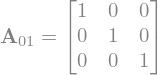

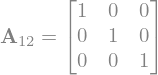

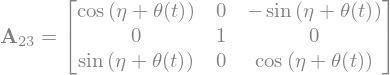

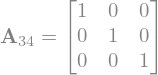

In [9]:
# tower top rotation (due to tower deformation)
A_01 = red( rotate_matrix(q[11], 'x').T * rotate_matrix(q[12], 'z').T ).T

# Shaft tilt
A_12 = rotate_matrix(tilt, 'x')

# Shaft tip azimutal position (blade 0)
A_23 = rotate_matrix(theta + eta + q[13], 'y') # rotor azimutal position (blade 0)

# Rotor conning
A_34 = rotate_matrix(cone, 'x')  

# Combined transformation tensors
A_04 = red( A_01.T * A_12.T * A_23.T * A_34.T ).T

# Printing the equations
lhs_print('\mathbf{A}_{01}', A_01)
lhs_print('\mathbf{A}_{12}', A_12)
lhs_print('\mathbf{A}_{23}', A_23)
lhs_print('\mathbf{A}_{34}', A_34)

In [10]:
transformation_matrices = {}
transformation_matrices['A_01'] = A_01.xreplace({theta_dot: Omega})
transformation_matrices['A_12'] = A_12.xreplace({theta_dot: Omega})
transformation_matrices['A_23'] = A_23.xreplace({theta_dot: Omega})
transformation_matrices['A_34'] = A_34.xreplace({theta_dot: Omega})

## Angular velocity tensors
 
The angular velocity tensors are calculated using eqs. (2.26) to (2.29).

$$
{}_{_1}\boldsymbol{\Omega}_{01} = \mathbf{A}_{01} \cdot \frac{d}{dt}\left(\mathbf{A}_{01}^{T}\right)
$$
$$
{}_{_3}\boldsymbol{\Omega}_{23} = \mathbf{A}_{23} \cdot \frac{d}{dt}\left(\mathbf{A}_{23}^{T}\right)
$$

$$
{}_{_3}\boldsymbol{\Omega}_{01} = \mathbf{A}_{23} \cdot \mathbf{A}_{12} \cdot {}_{_1}\boldsymbol{\Omega}_{01} \cdot \mathbf{A}_{12}^{T} \cdot \mathbf{A}_{23}^T
$$
$$
{}_{_4}\boldsymbol{\Omega}_{01} = \mathbf{A}_{34} \cdot {}_{_3}\boldsymbol{\Omega}_{01} \cdot \mathbf{A}_{34}^{T}
$$
$$
{}_{_4}\boldsymbol{\Omega}_{23} = \mathbf{A}_{34} \cdot {}_{_3}\boldsymbol{\Omega}_{23} \cdot \mathbf{A}_{34}^{T}
$$

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   9 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Don

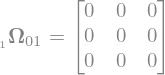

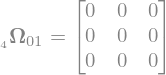

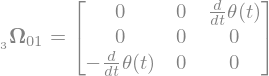

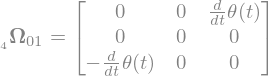

In [11]:
Omega_01_1 = matrix_simplify( A_01 * A_01.T.diff(t) )
Omega_01_3 = matrix_simplify( A_23*A_12 * Omega_01_1 * A_12.T*A_23.T )
Omega_01_4 = matrix_simplify( A_34*A_23*A_12 * Omega_01_1 * A_12.T*A_23.T*A_34.T )

Omega_23_3 = matrix_simplify( A_23 * A_23.T.diff(t) )
Omega_23_4 = matrix_simplify( A_34 * Omega_23_3 * A_34.T )

# Printing the equations
lhs_print('{}_{_1}\mathbf{\Omega}_{01}', Omega_01_1)
lhs_print('{}_{_4}\mathbf{\Omega}_{01}', Omega_01_4)
lhs_print('{}_{_3}\mathbf{\Omega}_{01}', Omega_23_3)
lhs_print('{}_{_4}\mathbf{\Omega}_{01}', Omega_23_4)

In [12]:
rotation_matrices = {}
rotation_matrices['Omega_01_1'] = Omega_01_1.xreplace({theta_dot: Omega})
rotation_matrices['Omega_01_3'] = Omega_01_3.xreplace({theta_dot: Omega})
rotation_matrices['Omega_01_4'] = Omega_01_4.xreplace({theta_dot: Omega})
rotation_matrices['Omega_23_3'] = Omega_23_3.xreplace({theta_dot: Omega})
rotation_matrices['Omega_23_4'] = Omega_23_4.xreplace({theta_dot: Omega})

## Local position vectors

$\mathbf{r}_{t}$ is the position vector from the base of the turbine tower to it's top, $u_{t,x}\left(t\right)$ and $u_{t,y}\left(t\right)$ are the tower top elastic displacement on the ${}_{_0}x$ and ${}_{_0}y$ directions respectively and $h_t$ is the tower height. ${}_{_3}r_{s}$ is a position vector from the tower top to the shaft tip on reference frame $O_3$ where $s_l$ is the shaft length. Finally ${}_{_4}\mathbf{r}_{b}$ is the position vector of a blade defined on the blade coordinate system reference frame.

$$
{}_{_0}\mathbf{r}_t = \begin{bmatrix} u_{t,x}\left(t\right) \\ u_{t,x}\left(t\right) \\ -h_t \end{bmatrix}
\quad
{}_{_3}\mathbf{r}_s =\left[\begin{matrix}0\\- s_{l}\\0\end{matrix}\right]
\quad
{}_{_4}\mathbf{r}_b = \begin{bmatrix} x_{b}\left(t,z\right) \\ y_{b}\left(t,z\right) \\ z \end{bmatrix}
$$

The blades section position ${}_{_4}\mathbf{r}_b$ and displacement is modelled by a modal expansion defined on its moving reference frame. The first term in equations below represent the initial or non-deformed position of the blade section in relation to the blade root. The second terms represent the displacement in relation to the non-deformed position where $\phi_{i, x}\left(z\right)$ and $\phi_{i, y}\left(z\right)$ are the $i^{th}$ blade mode shapes on the edge and flapwise directions respectively and $q_i\left(t\right)$ are the blades modal coordinates. In this work, only three mode shapes are used to describe motion of the blades, namely the first flap-wise, the first edge-wise and the second flap-wise modes.

$$
x_{b}\left(t, z\right) = x_{b}\left(t_0, z\right) + \sum_{i=0}^{n} q_{3b+i}\left(t\right) \phi_{i, x}\left(z\right)
$$
$$
y_{b}\left(t, z\right) = y_{b}\left(t_0, z\right) + \sum_{i=0}^{n} q_{3b+i}\left(t\right) \phi_{i, y}\left(z\right)
$$

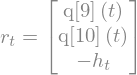

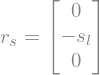

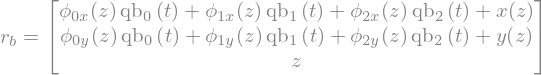

In [13]:
# Tower top position (frame 0)
r_t = sym.Matrix([ ut_x, ut_y, -h_t])

# Shaft end position (frame 3)
r_s = sym.Matrix([ 0, -s_l, 0])

# Blade section position (frame 5)
r_b = sym.Matrix([qb[0:3,0].T*phi_x, qb[0:3,0].T*phi_y, [z]]) + sym.Matrix([x, y, 0])


lhs_print('r_t', r_t)
lhs_print('r_s', r_s)
lhs_print('r_b', r_b)

In [14]:
position_vectors = {}
position_vectors['r_t0'] = r_t
position_vectors['r_s3'] = r_s
position_vectors['v_t0'] = r_t.diff(t)

## Absolute position vectors

The position vector of a blade element on the inertial reference frame and on the blade reference frame are given by the equations given below respectively. The position vector in the inertial reference frame is more convenient for calculating the gravitational potential energy, while the position vector on the blade reference frame is more convinient for calculating the non-conservative work done by the aerodynamic forces on the blade.

$$
{}_{_0}\mathbf{r}\left(t\right) = {}_{_0}\mathbf{r}_t\left(t\right) + \mathbf{A}_{01}^{T}\left(t\right) \cdot \mathbf{A}_{12}^{T} \cdot \mathbf{A}_{23}^{T}\left(t\right) \cdot \left[{}_{_3}\mathbf{r}_s + \mathbf{A}_{34}^{T} \cdot {}_{_4}\mathbf{r}_b\left(t\right) \right]
$$

$$
{}_{_4}\mathbf{r} = \mathbf{A}_{04}^{T}\left(t\right) \cdot {}_{_0}\mathbf{r}_t\left(t\right) +\mathbf{A}_{34}^{T} \cdot {}_{_0}\mathbf{r}_s + {}_{_0}\mathbf{r}_b 
$$


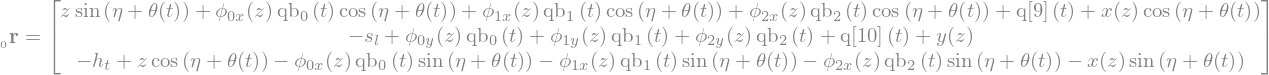

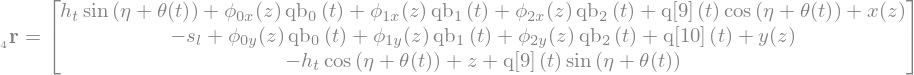

In [15]:
# Total position (frame 0)
r_0 = r_t + red(A_01.T*A_12.T*A_23.T) * (r_s + A_34.T * r_b)
r_0 = r_0.expand()

# Total position (frame 6)
r_4 = A_04*r_t + A_34*r_s + r_b

# Printing the equations
lhs_print('{}_{_0}\mathbf{r}', r_0)
lhs_print('{}_{_4}\mathbf{r}', r_4)

In [16]:
# Dictionary substitutions
r_0_b0 = r_0.xreplace(dict_b0) # blade 0, reference frame 0
r_0_b1 = r_0.xreplace(dict_b1) # blade 1, reference frame 0
r_0_b2 = r_0.xreplace(dict_b2) # blade 2, reference frame 0
r_4_b0 = r_4.xreplace(dict_b0) # blade 0, reference frame 4
r_4_b1 = r_4.xreplace(dict_b1) # blade 1, reference frame 4
r_4_b2 = r_4.xreplace(dict_b2) # blade 2, reference frame 4

## Absolute blade velocity vector in blade frame (frame 4)

The absolute velocity is obtained taking the derivative of the position equation. However, it is often more convenient to express the velocity in the local referential frame, which is achieved simply multiplying the terms in the velocity vector equation by the transformation tensors.

$$
{}_{_4}\mathbf{v}\left(t\right) = \mathbf{A}_{04} \cdot \frac{d}{dt}\left({}_{_0}\mathbf{r}_t\right) +  \mathbf{A}_{34} \cdot \left[ {}_{_3}\mathbf{\Omega}_{01}\left(t\right) + {}_{_3}\mathbf{\Omega}_{23}\left(t\right) \right] \cdot {}_{_3}\mathbf{r}_s + \left[ {}_{_4}\mathbf{\Omega}_{01}\left(t\right) + {}_{_4}\mathbf{\Omega}_{23}\left(t\right) \right] \cdot {}_{_4}\mathbf{r}_b\left(t\right) + \frac{d}{dt}\left({}_{_4}\mathbf{r}_b\right)
$$

The absolute velocity vector is generally more compact when written in the object frame of reference. The velocity equation derived does not require to be simplified. The kinetic energy is an scalar and does not depend of the frame of reference in which the velocity is described, but the time used to simplify the kinetic energy equation is greatly affected by it.

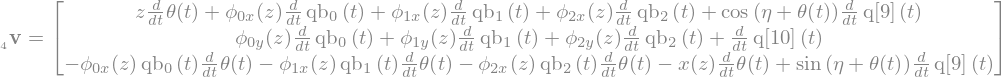

In [17]:
v_4 = A_04*r_t.diff(t) + A_34*(Omega_01_3 + Omega_23_3)*r_s + (Omega_01_4 + Omega_23_4)*r_b + r_b.diff(t)             
v_4 = v_4.expand()

# Printing the equations
lhs_print('{}_{_4}\mathbf{v}', v_4)

# Kinectic energy

It is always possible to derive the systems equations of motion from the direct application of Newton's laws of motion. However, the Lagrange or energy method often offer a more straightforward and automatic method to implement with the aid of symbolic computational tools. In addition to simplifying the process of obtaining the equations of motion, the use of computational math packages is especially convenient for automatic code generation as will be show later. In order to derive the equations of motion using the Lagrange method is first necessary to derive the kinetic and potential energy of the wind turbine and the work done by non-conservative forces acting on it as a function of the generalised degrees of freedom.

The total kinetic energy associated with the motion of the wind turbine is given by the equation below. The first term represents the kinetic energy associated with the nacelle and hub translation velocity while the second and third terms represents the energy associated with its angular velocity. The fourth term is the integral of the energy associated with the translation of the blade segments along the three blades. It must be noted that the energy associated with the rotation of the blades segments around their respective centre of mass is small and is therefore disregarded.

$$
E_{kin} = \frac{1}{2} \left(m_n+m_h\right) \left[ \dot{u}_{t,x}^{2}\left(t\right) + \dot{u}_{t,x}^{2}\left(t\right) \right] + \frac{1}{2} I_{t,x} \dot{\theta}_{t,x}^{2}\left(t\right) + \frac{1}{2} I_{t,z} \dot{\theta}_{t,z}^{2}\left(t\right) + \frac{1}{2}\sum_{b=0}^{n_b}  \int_{z_0}^{z_R} m\left(z\right) v_b^2\left(t, z\right) dz
$$

It is important to note that the mode shapes are declared as undefined functions of $z$, i.e. the code does not know the integral of ortohogonal mode shapes is zero, and the product of two orthogonal mode shapes must be substituded by zero.

In [18]:
# Velocity squared (generic blade)
vs = (v_4.T * v_4)[0].doit().expand()

# Eliminating the product of orthogonal mode-shapes
vs = vs.subs(dict_mode_shapes_product)

# Velocity squared (blades 0, 1 and 2)
vs_b0 = vs.xreplace(dict_b0)
vs_b1 = vs.xreplace(dict_b1)
vs_b2 = vs.xreplace(dict_b2)

# Tower kinetic energy
E_kin_0 = sym.Rational(1, 2)*(m_n+m_h)*( sym.diff(ut_x, t)**2 + sym.diff(ut_y, t)**2 ) + sym.Rational(1, 2)*(I_x*sym.diff(theta_tx, t)**2 + I_z*sym.diff(theta_tz, t)**2)

# Blades kinetic energy
E_kin_1 = sym.Rational(1, 2)*(m*(vs_b0+vs_b1+vs_b2) *dz)

# Total kinetic 
E_kin = E_kin_0 + E_kin_1
E_kin = E_kin.doit().expand()

# Integrating over the blade length
E_kin = func_integrate_par(E_kin, dz, z, R)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 tasks      | elapsed:   28.5s
[Parallel(n_jobs=2)]: Done  91 out of  91 | elapsed:  1.5min finished


E_kin = 


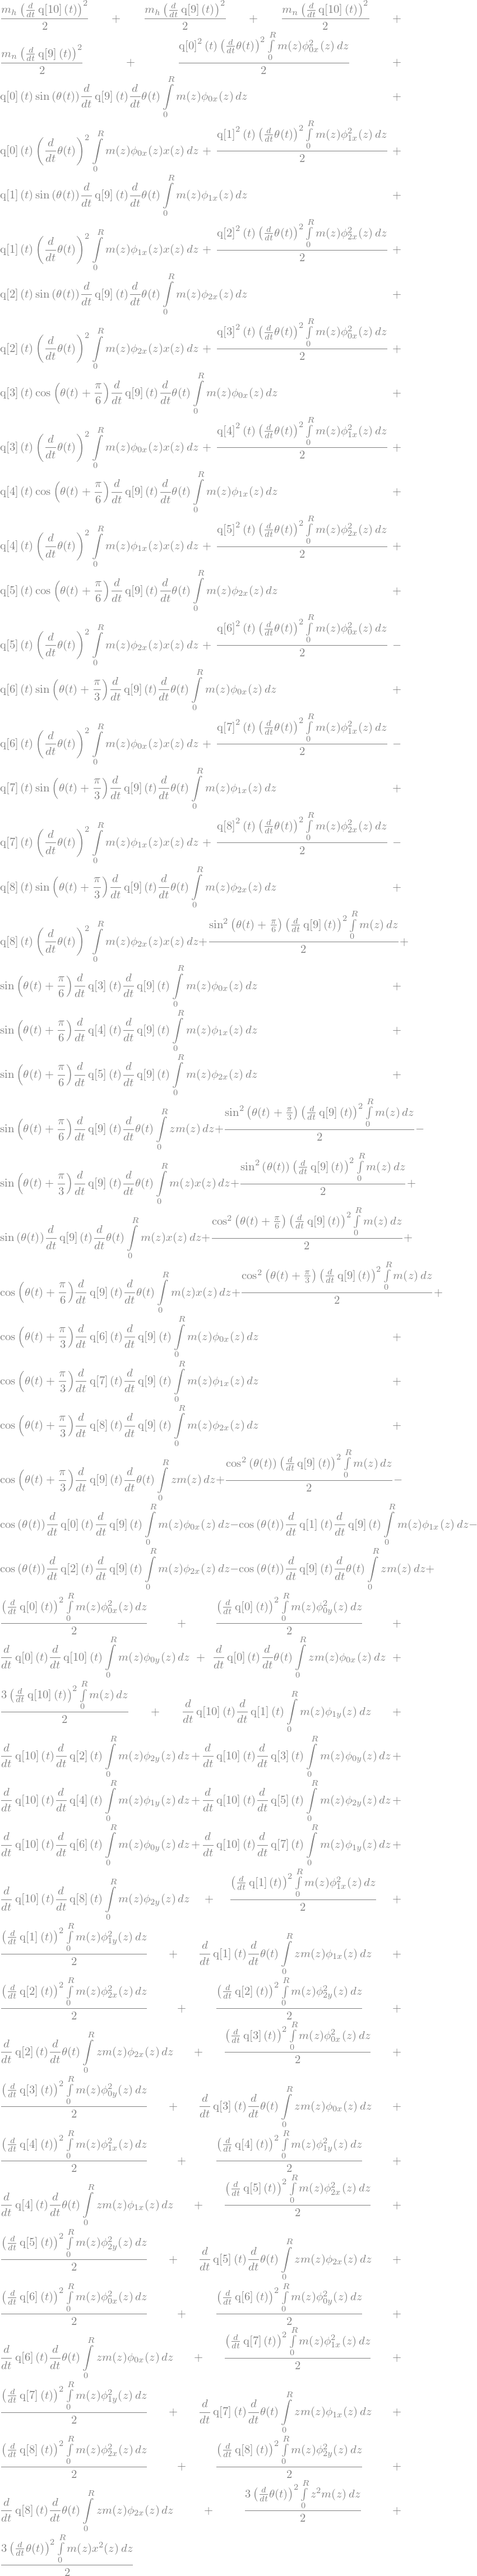

In [19]:
# Printing the equation
print('E_kin = '); E_kin

# Potential energy

The total potential energy of the wind turbine is given by the equation below. The first term is associated with the energy necessary to deflect the tower top where $k_{t,x}$ and $k_{t,y}$ are the forward and lateral translational stiffness respectively, $g_{t,x}$ is the bending stiffness and $g_{t,z}$ is the tower yawing stiffness. The second term is associated with the shaft torsion energy, where $g_{s,y}$ is the shaft torsional stiffness. The third term is associated with the blades deflection energy, where the blade resistance to deflection in modal coordinates is expressed in terms of its of its modal stiffness. The last term represents the blades potential energy where ${}_{_0}r_{b,z}$ is blade position vector in the inertial reference frame and the minus sign is related to the direction of $z$ axis in the inertial reference frame.

$$
E_{pot} = \frac{1}{2} \left[k_{t, x} u_{t,x}^2\left(t\right) + k_{t, y} u_{t,y}^2\left(t\right) + g_{t,x} \theta_{t,x}^{2}\left(t\right) + g_{t,z} \theta_{t,z}^{2}\left(t\right)  \right] + \frac{1}{2} \left[g_{s, y} \theta_{s}^{2} \right] + \sum_{b=0}^{n_b} \sum_{i=0}^{n_m} \omega_{i}^{2} \int_{z_0}^{z_R} m\left(z\right) \left[\phi_{i,x}^2\left(z\right) + \phi_{i,y}^2\left(z\right)\right] q_{3b+i}\left(t\right) dz - \sum_{b=0}^{n_b} g \int_{z_0}^{z_R} m\left(z\right) {}_{_0}r_{b,z}\left(t, z\right) dz
$$

It is important to note that the modal stiffness does not account for the blade stiffening due to the centrifugal forces. As the rotor angular speed increases, so does the centrifugal forces and the blade tension in the z direction. This tension increases the stiffness on the x and y directions as well.

In [20]:
# Tower potential energy
E_pot_T = sym.Rational(1, 2)*( k_x*ut_x**2 + k_y*ut_y**2 + Gt_x*theta_tx**2 + Gt_z*theta_tz**2 + Gs_y*theta_sy**2 + Gt_xy*ut_y*theta_tx )

# Blade stiffness potential energy (generic blade)
E_pot_m = 0
for i in range(3):
    E_pot_m += sym.Rational(1, 2)*(omega[i]**2*m*((phi_x[i]**2+phi_y[i]**2)*dz)*qb[i]**2)

# Blades gravitational potential energy  (generic blade)
E_pot_g = (m * g * (-r_0[2]) * dz)
E_pot_b = E_pot_m + E_pot_g
del E_pot_m, E_pot_g

# Blades potential energy (blades 0, 1 and 2)
E_pot_b0 = E_pot_b.xreplace(dict_b0)
E_pot_b1 = E_pot_b.xreplace(dict_b1)
E_pot_b2 = E_pot_b.xreplace(dict_b2)

# Total potential energy
E_pot = E_pot_T + E_pot_b0 + E_pot_b1 + E_pot_b2
E_pot = E_pot.doit().expand()

# Integrating over the blade length
E_pot = func_integrate_par(E_pot, dz, z, R)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   11.7s finished


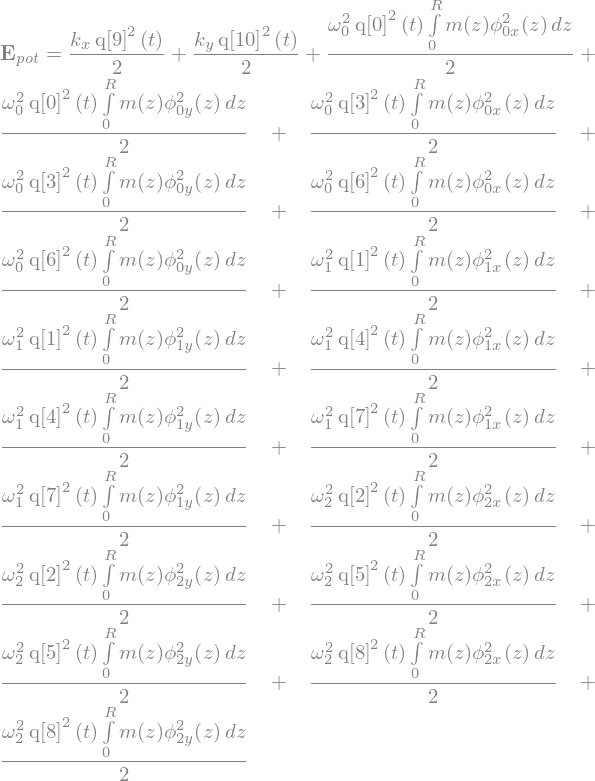

In [21]:
# Printing the equation
lhs_print('\mathbf{E}_{pot}', E_pot)

# Non-conservative forces

The work from the aerodynamic forces on the blades is calculated using eq.(2.70). For the calculating the aerodynamic work it is convenient to describe both the blade position and blade forces on the blade frame of reference. The blade position equation $\mathbf{r}\left(z, t\right)$ is smaller on the blade frame and the aerodynamic forces $\mathbf{f}\left(z, t\right)$ are calculated on it.

$$
\mathcal{W}^{\left(nc\right)} =\sum_{b=0}^{n_b} \int_{z_0}^{z_R} {}_{_4}\mathbf{f}\left(z, t\right) \cdot {}_{_4}\mathbf{r}\left(z, t\right)  dz
$$

In [22]:
# Non-conservative work done by aerodynamic forces on the blade (generic blade)
W_b = ((f_b.T * r_4)[0] * dz).doit().expand()

# Non-conservative work done by aerodynamic forces on the blade (blades 0, 1 and 2)
W_b0 = W_b.xreplace(dict_b0)
W_b1 = W_b.xreplace(dict_b1)
W_b2 = W_b.xreplace(dict_b2)

# Total non-conservative work
W = (W_b0 + W_b1 + W_b2).doit().expand()

# Integrating over the blade length
W = func_integrate_par(W, dz, z, R)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:   12.3s finished


W = 


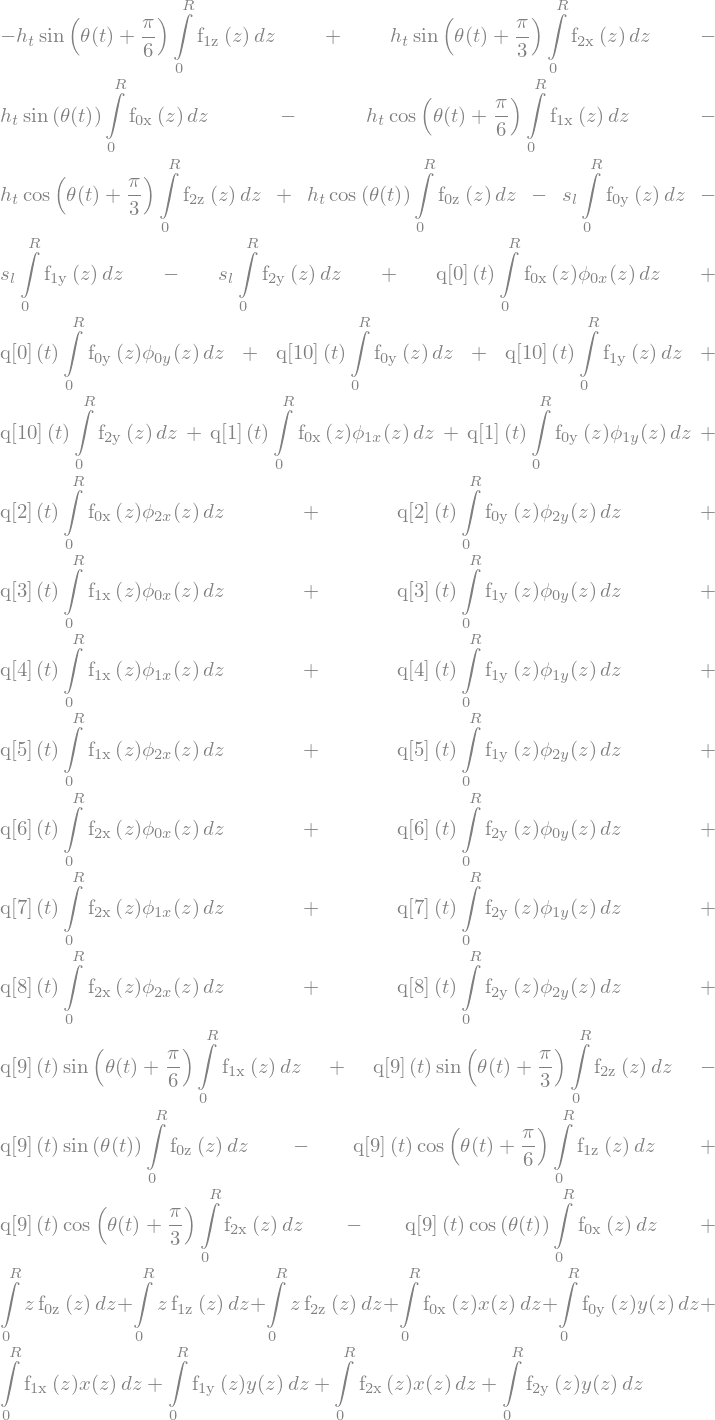

In [23]:
# Printing the equation
print('W = '); W

### Gathering the similar integral terms on the E_kin, E_pot and W

For different reasons, it is convenient to gather the integral terms in E_kin, E_pot and W.
- The integrals are neither a function of time nor the q_j, thus they are not affected by the differentiation in the Lagrange equation.
- The simplification algorithm does not work if an undefined integral is present in the equation, i.e. it is code bug.
- The equations of kinetic energy, potential energy and non-conservative work contains similar integrals. In terms in code performance, it means that they can be gathered together and calculated only once. In a compiled code, usually good compilers check for similar computations automatically to improve the code performance and the programmer do not have to worry about it. On interpreted codes, this usually not the case. The integrals are organised in a set to eliminate duplicated items, then into a list to enumerate them and then into a dictionary so a symbol can be assigned to them. The dictionary is then used to replace the integrals on the E_kin, E_pot and W. When generating the numerical code, the integrals are calculated previously and then substituted into M, C, K and F.

In [24]:
# List of integrals in E_kin, E_pot and W
i_set = E_kin.atoms(sym.Integral) | E_pot.atoms(sym.Integral) | W.atoms(sym.Integral)
i_list = list(i_set)

# Arrange the list of itegrals into a dictionary
x_list = sym.symbols('xint[:%d]' %len(i_list))
dict_xi = dict(zip(x_list, i_list))
dict_ix = dict(zip(i_list, x_list))

# Replace the integrals on E_kin, E_pot and W
E_kin = E_kin.xreplace(dict_ix)
E_pot = E_pot.xreplace(dict_ix)
W = W.xreplace(dict_ix)

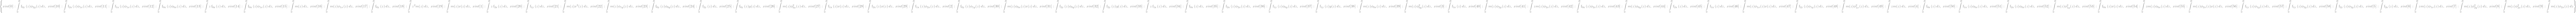

In [25]:
# display the dictionary
dict_xi

# Lagrange equations

In Lagrangian mechanics, the equations of motion of a system is derived by solving the Lagrange equations. It is worth mentioning that the constraints of the system may be set of extra equations using the Lagrange multipliers or by incorporating the constraints in the choice of the generalised coordinates, the second method is the one used in this work while the first is often employed in many cases without mentioning the distinction. The same results can be achieved by employing the Newtonian mechanics directly, applying Lagrangian mechanics is more laborious but also more systematic and thus often convenient with the aid of mathematical packages.

$$
\mathbf{E}\left[j\right] = \frac{d}{d t}\left(\frac{\partial E_{kin}}{\partial \dot{q}_j}\right) - \frac{\partial E_{kin}}{\partial q_j} + \frac{\partial E_{pot}}{\partial q_j} - \frac{\partial \mathcal{W}^{\left(nc\right)}}{\partial q_j}
$$

In [26]:
# Find the length of q
for i_q in range(len(q)):
    if (q[i_q]!=0):
        len_q = i_q+1

q = q[:len_q,:]
q_dot = q_dot[:len_q,:]
q_ddot = q_ddot[:len_q,:]

In [27]:
# Find the length of q
for i_q in range(len(q)):
    if (q[i_q]!=0):
        len_q = i_q+1

q = q[:len_q,:]
q_dot = q_dot[:len_q,:]
q_ddot = q_ddot[:len_q,:]

E = sym.zeros(q.shape[0], q.shape[1])
def func_lagrange(E, E_kin, E_pot, q, t, i):
    q_dot = q.diff(t, 1)
    t_1 = time.time()
    #--
    E = sym.diff(sym.diff(E_kin, q_dot[i]), t) - sym.diff(E_kin, q[i]) + sym.diff(E_pot, q[i]) - sym.diff(W, q[i])
    E = E.doit().subs({theta_ddot: 0}).subs({theta_dot: Omega}).doit().expand(trig=True)
    #--
    t_2 = time.time()
    file_log = open('file_log.txt', 'a')
    print((i, ), end=' ', file=file_log)
    print(t_2 - t_1, file=file_log)
    file_log.close()
    return (i, E)

totos = Parallel(n_jobs=n_cores, verbose=51)(delayed(func_lagrange)(E[i], E_kin, E_pot, q, t, i) for i in reversed(range(len(q))) )

for toto in totos:
    E[toto[0]] = toto[1]
del totos


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done   9 out of  11 | elapsed:    5.7s remaining:    1.3s
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    6.7s finished


#### Assmptions (small deflections and small velocities)

It is assumed the displacements, especially the angular displacements, are small so their trigonometric funcions can be simplified. However, in order to preserve the consistency in the equations, it is better to apply the simplifications after taking the derivatives on the Lagrange equation.

In [28]:
Ec = assumptions_madd(E, dict_small, dict_small_squared)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    4.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    4.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:   

## Matrices

It is convenient to rewrite the system of equations in terms of a inertia matrix $\mathbf{M}$, a stiffness matrix $\mathbf{K}$, a matrix $\mathbf{C}$ proportional to $\mathbf{\dot{q}}$ and a force vector $\mathbf{F}$ containing the remaining terms of the system of equations.

$$
\mathbf{E} = \mathbf{M}\cdot\mathbf{\ddot{q}} + \mathbf{C}\cdot\mathbf{\dot{q}} + \mathbf{K}\cdot\mathbf{q} - \mathbf{F} = \mathbf{0}
$$

This is achieved here using the symbolic module function "Coefficient" which identifies all terms proportional to the given variable. First the mass matrix is constructed selecting the terms of equatios $\mathbf{E}$ that are linearly proportional to each of the terms in the array $\mathbf{\ddot{q}}$. The remaining terms are then used to construct $\mathbf{C}$ and $\mathbf{K}$ in a similar way. The remaining terms are then equal to $- \mathbf{F}$.

$$
\mathbf{M}[i,j] = \text{Coefficient}(\mathbf{E}[i],\; \ddot{q}[j])
$$
$$
\mathbf{C}[i,j] = \text{Coefficient}(\left(\mathbf{E} - \mathbf{M}\cdot\ddot{\mathbf{q}}\right)[i],\; \dot{q}[j])
$$
$$
\mathbf{K}[i,j] = \text{Coefficient}(\left(\mathbf{E} - \mathbf{M}\cdot\ddot{\mathbf{q}} - \mathbf{C}\cdot\dot{\mathbf{q}}\right)[i],\; q[j])
$$
$$
\mathbf{F} = - \left(\mathbf{E} - \mathbf{M}\cdot\ddot{\mathbf{q}} - \mathbf{C}\cdot\dot{\mathbf{q}} - \mathbf{K}\cdot\mathbf{q}\right)
$$

In [29]:
print('M_matrix')
M_mat = coeficient_matrix_par(Ec, q_ddot)

print('C_matrix')
C_mat = coeficient_matrix_par((Ec - M_mat*q_ddot).doit().expand(trig=True), q_dot)

print('K_matrix')
K_mat = coeficient_matrix_par((Ec - M_mat*q_ddot - C_mat*q_dot).doit().expand(trig=True), q)

print('R_vector')
R_vec = (Ec - M_mat*q_ddot - C_mat*q_dot - K_mat*q).doit().expand(trig=True)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


M_matrix


[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


C_matrix


[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


K_matrix
R_vector


[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    3.0s finished


### Simplifying

Simplifying large equations symbolically is very costly, the computational time depends on the number of possible combinations of its terms. Thus, if the equation can be separated into smaller parts that can be simplified separately, the computational time decreases significantly and it also oppens up the possibility for parallelising the simplification process.

In [30]:
print('Simplifying')
M_mat = matrix_simplify(M_mat)
C_mat = matrix_simplify(C_mat)
K_mat = matrix_simplify(K_mat)
R_vec = matrix_simplify(R_vec)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Simplifying


[Parallel(n_jobs=2)]: Done 121 out of 121 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 121 out of 121 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 121 out of 121 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    1.1s finished


In [31]:
M_i = M_mat.xreplace(dict_xi)
C_i = C_mat.xreplace(dict_xi)
K_i = K_mat.xreplace(dict_xi)
R_i = R_vec.xreplace(dict_xi)

### Mass matrix

M =


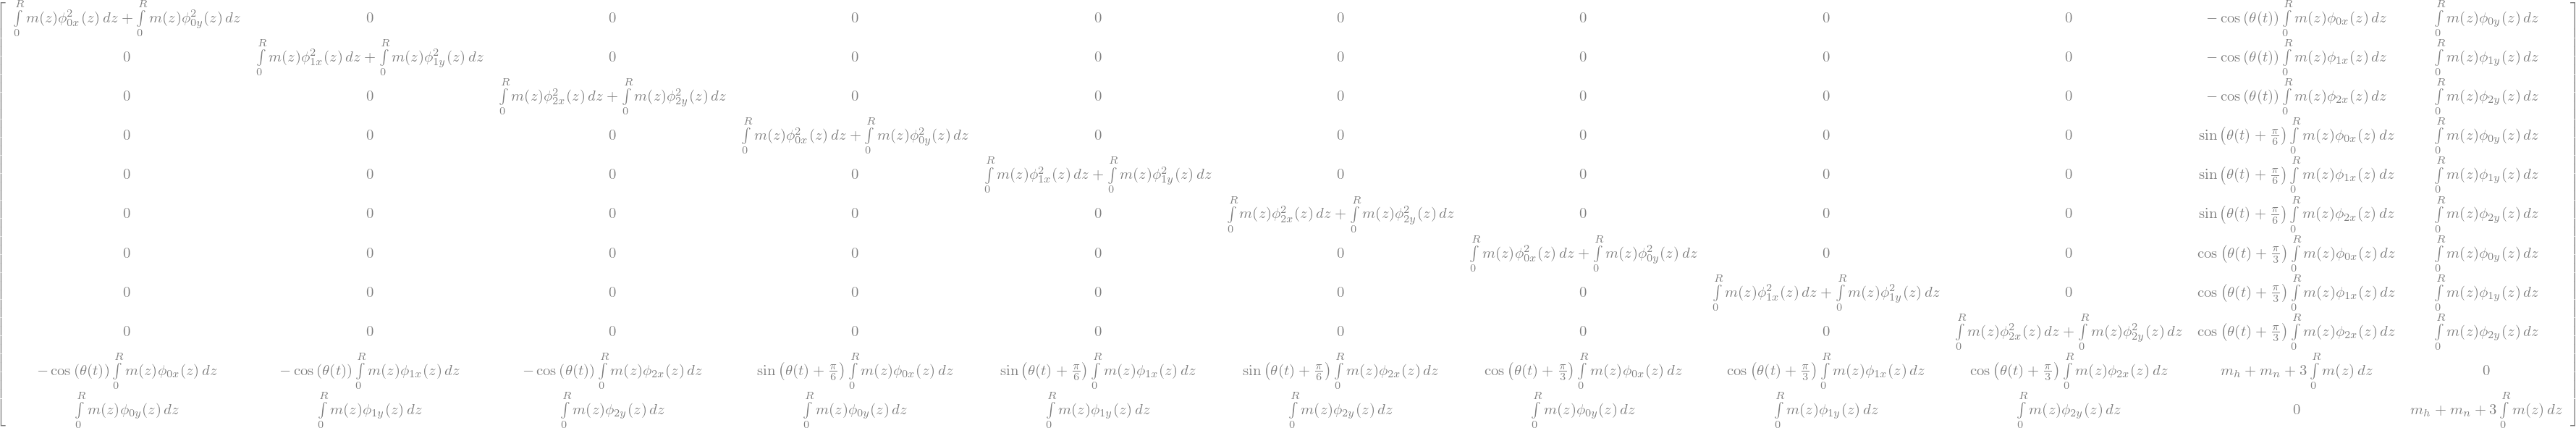

In [32]:
print('M ='); display(M_i)

### C matrix

C =


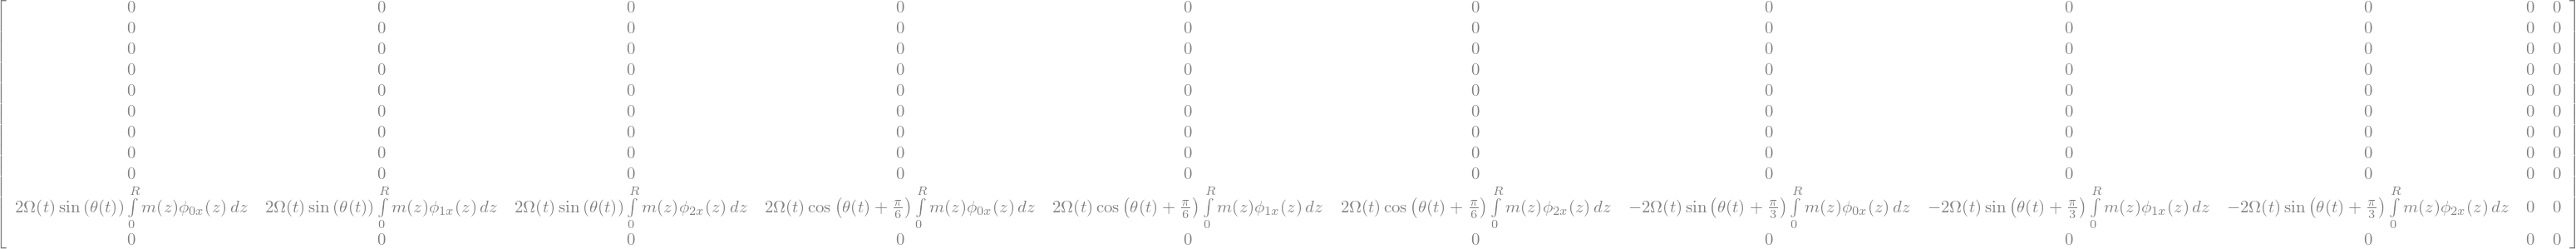

In [33]:
print('C ='); display(C_i)

### Stiffness matrix

K =


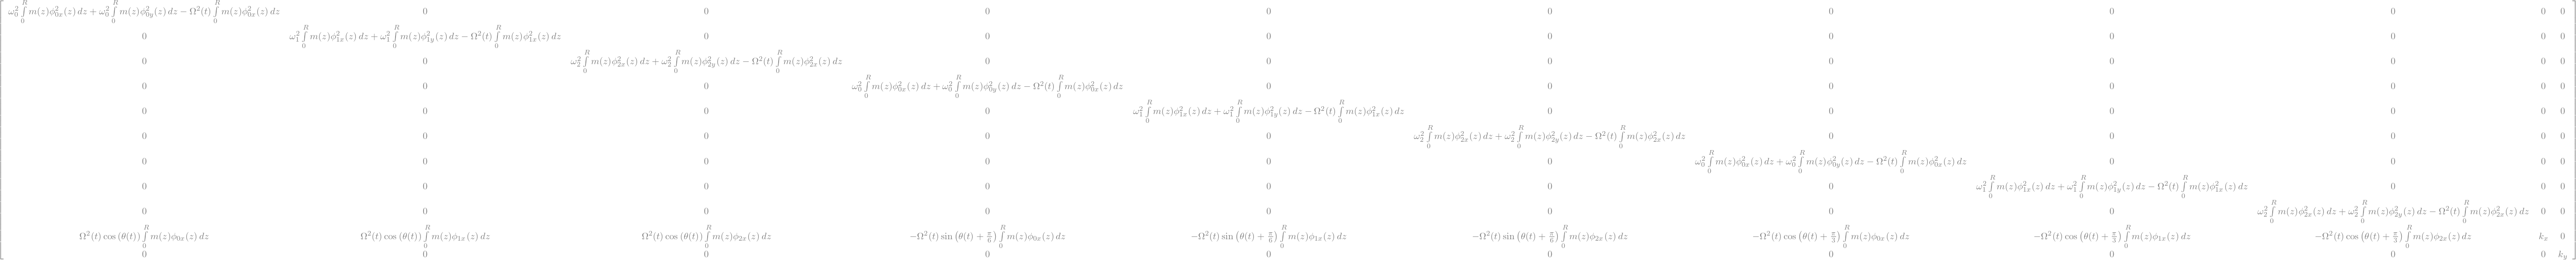

In [34]:
print('K ='); display(K_i)

### Forcing vector

F =


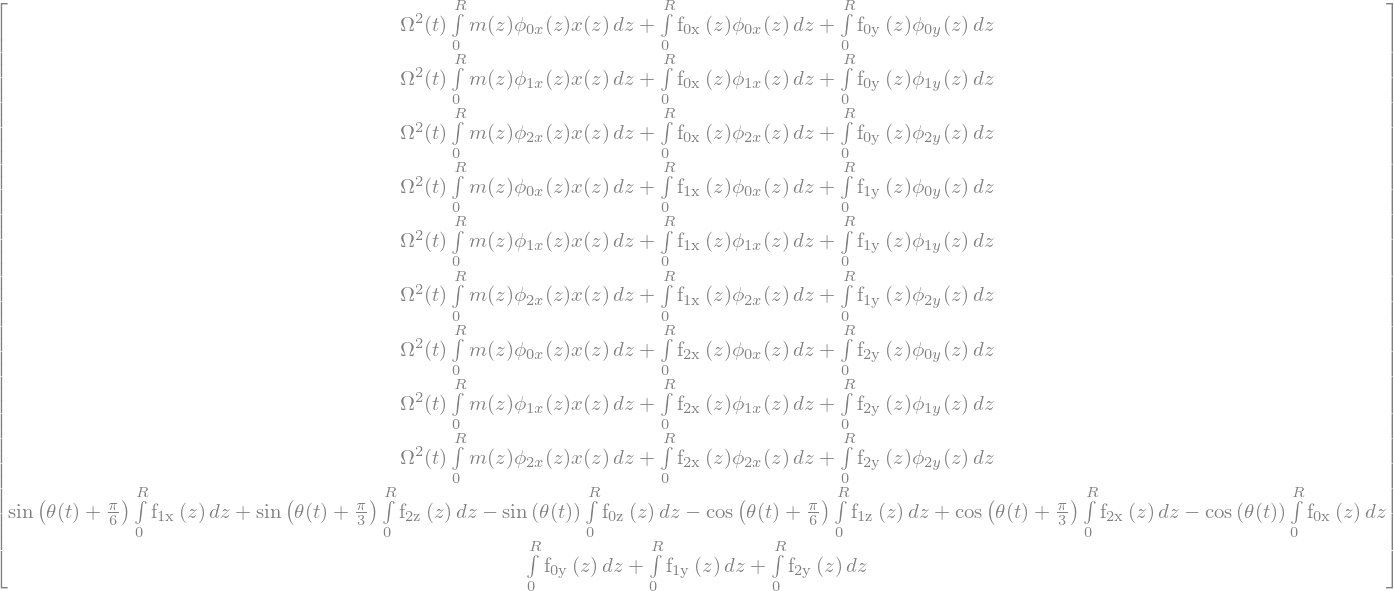

In [35]:
print('F ='); display(-R_i)

# Automatic code generation

Another convenience of Python is the possibility of adapting the functionality of a package to suit the project specific needs through inheritance of a class and overriding some of its methods. In the present case, the code generator “NumpyPrinter” from Sympy was inherited into the class “MyPrinter”.

The generation of a numerical code is the objective of the script. The method 'MyPrinter.gen_file' generates a python class with the methos to calculate the instantaneous blade section position, velocity, $\mathbf{M}$, $\mathbf{C}$, $\mathbf{K}$ matrices and $\mathbf{F}$ vector. Although python+numpy has been chosen in the project to generate the code, it is straightforward to generate similar codes using Fortran+Lapack or C++/Lapack.



## Gathering the trigonometric functions

Similar trigonometric functions appear in several terms in $\mathbf{M}$, $\mathbf{C}$, $\mathbf{K}$ matrices and $\mathbf{F}$ vector. Some of them change over time steps others do not. Pre-calculating the trigonometric functions once and only when necessary may improve the code speed, even thought this is not the intent of the project.

In [36]:
# List the common trigonometric trigonetric functions on M, C, K and R
trig_set = M_mat.atoms(sym.sin, sym.cos) | C_mat.atoms(sym.sin, sym.cos) | K_mat.atoms(sym.sin, sym.cos) | R_vec.atoms(sym.sin, sym.cos)
trig_list = list(trig_set)

# Arrange the list of trigonometric functions in a dictionary
y_list = sym.symbols('ytrig[:%d]' %len(trig_list))
dict_yt = dict(zip(y_list, trig_list))
dict_ty = dict(zip(trig_list, y_list))

# Replace the trigonometric functions on M, C, K and R
M_mat = M_mat.xreplace(dict_ty)
C_mat = C_mat.xreplace(dict_ty)
K_mat = K_mat.xreplace(dict_ty)
R_vec = R_vec.xreplace(dict_ty)

## Colecting the terms constant with time (iterations)

In [37]:
is_constant = [True]*len(x_list)
for i in range(len(x_list)):
    for atom in i_list[i].atoms(sym.Symbol, sym.Function, sym.Derivative):
        for iter_variable in iter_list:
            if (atom == iter_variable):
                is_constant[i] = False
    pass
dict_constant = dict(zip(x_list, is_constant))

## Generating the numerical code

The file wind_turbine_sctructural.py will be created.

In [38]:
Ei = Ec.copy().xreplace(dict_xi)

# Substitutes the variables names in dict_names
for key, value in dict_names.items():
    key.name, dict_names[key] = value, key.name

# Generate a list of the names of all symbols and functions (except intrinsic functions like trigonometric functions)
set_1 = ( f_0.atoms(sym.Symbol, sym.Function) | f_1.atoms(sym.Symbol, sym.Function) | f_2.atoms(sym.Symbol, sym.Function) | {Omega} | Ei.atoms(sym.Symbol, sym.Function) | set(x_list) | set(y_list) | r_0.atoms(sym.Function, sym.Symbol) | v_4.atoms(sym.Function, sym.Symbol) )
set_2 = ( Ei.atoms(sym.sin, sym.cos) | r_0.atoms(sym.sin, sym.cos) | v_4.atoms(sym.cos, sym.sin) )
list_e = list(set_1 - set_2)
list_names = [item.name for item in list_e]  

# Change the symbols and functions names to include the 'self.' prefix
for item in list_e:
    item.name = 'self.' + item.name

# Generate the numerical code
MyPrinter.gen_file(M_mat , C_mat, K_mat, -R_vec, q, dict_xi, dict_yt, dict_constant, transformation_matrices, rotation_matrices, position_vectors)

# Change the symbols and functions names back to their original values
for item, item_name in zip(list_e, list_names):
    item.name = item_name

# Substitutes the variables names back
for key, value in dict_names.items():
    key.name, dict_names[key] = value, key.name

In [39]:
t_end = time.time()
print("The numpy.code 'wind_turbine_structual.py' was written, Dave")
print('The simulation took %0.4f [s], Dave' %(t_end-t_start))

The numpy.code 'wind_turbine_structual.py' was written, Dave
The simulation took 233.1031 [s], Dave
